# IdpSAM notebook

## About
Welcome to the idpSAM Colab notebook. IdpSAM is a latent [diffusion model](https://en.wikipedia.org/wiki/Diffusion_model) to generate ensembles of 3D conformations of [intrinsically disordered peptides and proteins](https://en.wikipedia.org/wiki/Intrinsically_disordered_proteins) (IDPs).

You can use this notebook to generate an ensemble for a custom peptide sequence. When running on Colab, make sure to use GPU support (via `Edit` -> `Notebook settings`), otherwise the generation process will be significantly slower if you plan to generate large ensembles (> 1000 conformations).

IdpSAM was trained on data from Markov Chain Monte Carlo simulations of intrinsically disordered peptides (their sequence was obtained from [DisProt](https://www.disprot.org)). The simulations were carried out using [ABSINTH](https://pubmed.ncbi.nlm.nih.gov/18506808/), an [implicit solvent model](https://en.wikipedia.org/wiki/Implicit_solvation), implemented in the [CAMPARI 4.0](https://campari.sourceforge.net/V4/index.html) package.

NOTE: please be aware that the simulation protocol that we used contains numerous approximations and so the ensembles generated via idpSAM are likely only rough approximations of experimental ensembles!

## Usage

The notebook has three sections:
 1. **Setup**: you must run this section install the dependencies on Colab.
 2. **Input**: define the sequence of the peptide you want to model and choose option for idpSAM.
 3. **Run idpSAM**: actually run the model and generate an ensemble.
 4. **Analyze results**: visualize some properties of the ensemble (it's actually an optional section).
 5. **Download results**: download the structural ensemble that you generated.

## More information
For more details on idpSAM and its training data, please refer to: [Transferable deep generative modeling of intrinsically disordered protein conformations](https://www.biorxiv.org/content/ADD_CORRECT_URL).

For its source code, see: [idpSAM GitHub repository](https://github.com/giacomo-janson/idpsam).

---

# 1 - Setup

In [1]:
#@title Install dependencies

#@markdown Run this cell to install all the required dependencies for idpSAM. The installation will take place in the Colab notebook in the cloud. The whole process will take some minutes.

import os
import re
import shutil
import subprocess
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors, colormaps


os.environ["RUNNING_ON_COLAB"] = "1"
use_cg2all = False
install_steps = 4
cg2all_device = "cpu"

def install(cmd):
    o = subprocess.run(cmd, capture_output=True)

print("# Starting the installation process on the Colab cloud environment...")

# Install the SAM package.
print(f"- Installing the sam library (step 1/{install_steps}).")
if os.path.isdir("idpsam"):
    shutil.rmtree("idpsam")
install(["git", "clone", "https://github.com/giacomo-janson/idpsam.git"])
os.chdir("idpsam")
install(["pip", "install", "."])
os.chdir("..")

# Install other dependencies.
print(f"- Installing the diffusers library (step 2/{install_steps}).")
install(["pip", "install", "--upgrade", "diffusers[torch]"])

print(f"- Installing the py3Dmol library (step 3/{install_steps}).")
install(["pip", "install", "py3Dmol"])

# Install cg2all or mdtraj.
if not use_cg2all:
    print(f"- Installing the mdtraj library (step 4/{install_steps}).")
    install(["pip", "install", "mdtraj"])
else:
    print(f"- Installing mdtraj and cg2all (step 4/{install_steps}).")
    install(["pip", "install", "-q", "git+http://github.com/huhlim/cg2all"])

print("- Done.")

# Starting the installation process on the Colab cloud environment...
- Installing the sam library (step 1/4).
- Installing the diffusers library (step 2/4).
- Installing the py3Dmol library (step 3/4).
- Installing the mdtraj library (step 4/4).
- Done.


---

# 2 - Input

Use this section to specify the input sequence and options for idpSAM.

In [2]:
#@title Enter the amino acid sequence
name = "Q9EP54"  #@param {type:"string"}
sequence = "MACYPVNIRARGLGKNMGMKSRGRGKG"  #@param {type:"string"}

#@markdown Note: this version of idpSAM was trained with peptides with lengths between 12 and 60 amino acids. Therefore the model will likely produce bad results (e.g.: bad chain geometry and incorrect interaction patterns) for peptides with lengths significantly out of this range.

# Check input.
if not re.match(r'^[a-zA-Z0-9_-]*$', name):
    del name
    raise ValueError("Names can contain only the following characters: a-z A-Z 0-9 _ -")
if not re.match(r'^[QWERTYIPASDFGHKLCVNM]*$', sequence):
    del sequence
    raise ValueError("Sequences can contain only standard amino acid letters.")

In [3]:
#@title Options

from sam.model import SAM

# Hidden options.
config_fp = "idpsam/config/models.yaml"
out_dp = "output"
out_path = os.path.join(out_dp, "pept")

device = "cuda" if torch.cuda.is_available() else "cpu"

# User-defined.
#@markdown Number of conformations to generate:
n_samples = 1000 # @param {type:"integer"}
#@markdown Number of diffusion steps in the generation process (min=1, max=1000):
n_steps = 100 #@param {type:"integer"}
#@markdown Batch size:
batch_size = 500 #@param {type:"integer"}
#@markdown Reconstruct all-atom details from C-alpha conformations via the [cg2all model](https://github.com/huhlim/cg2all/tree/main):
all_atom = False #@param {type:"boolean"}
#@markdown cg2all batch size:
cg2all_batch_size = 250 #@param {type:"integer"}

# Check the input.
if not 1 <= n_steps <= 1000:
    raise ValueError("Invalid number of diffusion steps.")
if all_atom:
    if not use_cg2all:
        raise ValueError("Can not reconstruct all-atom conformations. cg2all installation on Colab was not successful. Please uncheck this option.")
    if n_samples % cg2all_batch_size != 0:
        raise ValueError(
            "The all-atom conversion script can only work when --batch_size"
            f" is an exact divisor of --n_samples. You provided"
            f" {cg2all_batch_size} and {n_samples}. Please manually"
            " adjust the values.")


### More information about the options

* `n_samples`: number of statistically independent C-alpha conformations to generate with idpSAM. For peptides with lengths below 50 residues, 5000 samples probably describe very well the entire conformational ensemble. For most applications, if you generate more samples you will not get much more information.
* `n_steps`: number of diffusion steps in the sampling process of the [denoising diffusion probabilistic model](https://arxiv.org/abs/2006.11239) of idpSAM. The lower the number, the faster the generative process is going to be. The default value is 100, which we found to work well empirically for C-alpha modeling. A value of 50 will also probably work well and sampling will be faster. But we found that going under 10 steps will result in results numerous clashes and incorrect interaction patterns. <!-- Note: if your goal is to generate an all-atom ensemble of the highest possible stereochemical quality, you should use as many steps as possible (ideally 1000), because modeling with more steps helps to remove small inaccuracies in the C-alpha geometry.-->
* `batch_size`: batch size for all the neural network models used in this notebook. Ideally, larger values will result in faster sampling (since more conformations will be processed in parallel in the same batch). However, using values being too high will result in out-of-memory errors on Colab, especially when using a GPU. For idpSAM, memory consumptions is roughly quadratic with protein length, so for smaller sequences you can safely use larger batch sizes.
* `all_atom`: when this option is used, the [cg2all model](https://github.com/huhlim/cg2all/tree/main) will convert the C-alpha conformations from idpSAM to all-atom structures.
* `cg2all_batch_size`: batch size of cg2all. Only takes effect when the `all_atom` option is used. If for longer peptides the script crashes, try to decrease its value.

---

# 3 - Run idpSAM

In [4]:
#@title Initialize idpSAM

#@markdown Run this cell to load a pre-trained idpSAM model.

# Initialize the idpSAM model.
idpsam = SAM(config_fp=config_fp,
             device=device,
             weights_parent_path="idpsam",
             verbose=True)

# Setting up a SAM model from: idpsam/config/models.yaml.
- Using device 'cuda'.
- Loading epsilon network from: idpsam/weights/v1.0/nn.eps.pt.


/usr/local/lib/python3.11/dist-packages/sam/model.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.eps_model.load_state_dict(torch.load(eps_fp, **map_location_args)

- Loading decoder network from: idpsam/weights/v1.0/nn.dec.pt.


In [5]:
#@title Generate C-alpha conformations

#@markdown Run this cell to actually generate conformations!

#@markdown Note: if you are using CPUs it will probably take tens of minutes with the default options of this notebook.

# Generate C-alpha conformations.
out_data = idpsam.sample(
    seq=sequence,
    n_samples=n_samples,
    n_steps=n_steps,
    batch_size_eps=batch_size,
    return_enc=False,
    prot_name=name,
    out_type="numpy")

# Create the output directory.
if not os.path.isdir(out_dp):
    os.mkdir(out_dp)

# Save the conformations.
save_data = idpsam.save(
    out=out_data,
    out_path=out_path,
    out_fmt="dcd")

# Generating encodings for 1000 samples.
- seq: MACYPVNIRARGLGKNMGMKSRGRGKG
- Setting up a dataloader for encodings.
- Loading enc=torch.Size([1000, 27, 16]) for Q9EP54
- Generating...
- Generated 500 conformations of 1000
- Generated 1000 conformations of 1000
- Done.
# Decoding 1000 samples.
- Setting up a dataloader for xyz conformations.
- Loading xyz=(1000, 27, 3) for Q9EP54
- Decoding.
- Decoded 500 graphs of 1000
- Decoded 1000 graphs of 1000
- Done.
# Saving output.
- Saving a FASTA sequence file to: output/pept.seq.fasta.
- Saving a C-alpha trajectory dcd file to: output/pept.ca.traj.dcd.
- Saving a C-alpha topology PDB file to: output/pept.ca.top.pdb.


In [6]:
#@title Optional: build all-atom structures
#@markdown This will be run only if you checked the `all_atom` option.

if all_atom:
    cg2all_data = idpsam.cg2all(
        ca_pdb_fp=save_data["ca_pdb"],
        ca_traj_fp=save_data["ca_dcd"],
        out_path=out_path,
        batch_size=cg2all_batch_size,
        device=cg2all_device)
else:
    print("# Will not build all-atom structures.")

# Will not build all-atom structures.


---

# 4 - Analyze results

In this section you can quickly analyze some quick properties of the ensemble you generated.

In [7]:
#@title Carbon alpha properties of the ensemble

#@markdown **Run the analysis**

import mdtraj
from sam.coords import calc_dmap, calc_dmap_triu, torch_chain_dihedrals
import sklearn.decomposition

print("# Analyzing...")

traj = mdtraj.load(save_data["ca_dcd"], top=save_data["ca_pdb"])
traj.center_coordinates()
prot_data = {}

# PCA.
print("- Performing PCA")
dt = calc_dmap_triu(traj.xyz, backend="numpy")
pca = sklearn.decomposition.PCA(n_components=10)
pca.fit(dt)
prot_data["pca"] = pca.transform(dt)

# Distance map.
dmap = calc_dmap(traj.xyz, backend="numpy")
diag_indices = np.diag_indices(dmap.shape[2])
tril_indices = np.tril_indices(dmap.shape[2])
prot_data["dmap"] = dmap.mean(axis=0)
# prot_data[prot_name]["dmap"][0, diag_indices[0], diag_indices[1]] = np.nan
prot_data["dmap"][0, tril_indices[0], tril_indices[1]] = np.nan

# Contact map.
prot_data["cmap"] = np.sum(dmap <= 0.8, axis=0)/dmap.shape[0]
# prot_data[prot_name]["cmap"][0, diag_indices[0], diag_indices[1]] = np.nan
prot_data["cmap"][0, tril_indices[0], tril_indices[1]] = np.nan

# Rg
print("- Computing Rg")
prot_data["rg"] = mdtraj.compute_rg(traj)

# a torsions.
print("- Computing alpha torsions")
prot_data["tors"] = torch_chain_dihedrals(traj.xyz, backend="numpy").ravel()

# Analyzing...
- Performing PCA
- Computing Rg
- Computing alpha torsions


/usr/local/lib/python3.11/dist-packages/sam/coords.py:83: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  b0xb1 = torch.cross(b0, b1)


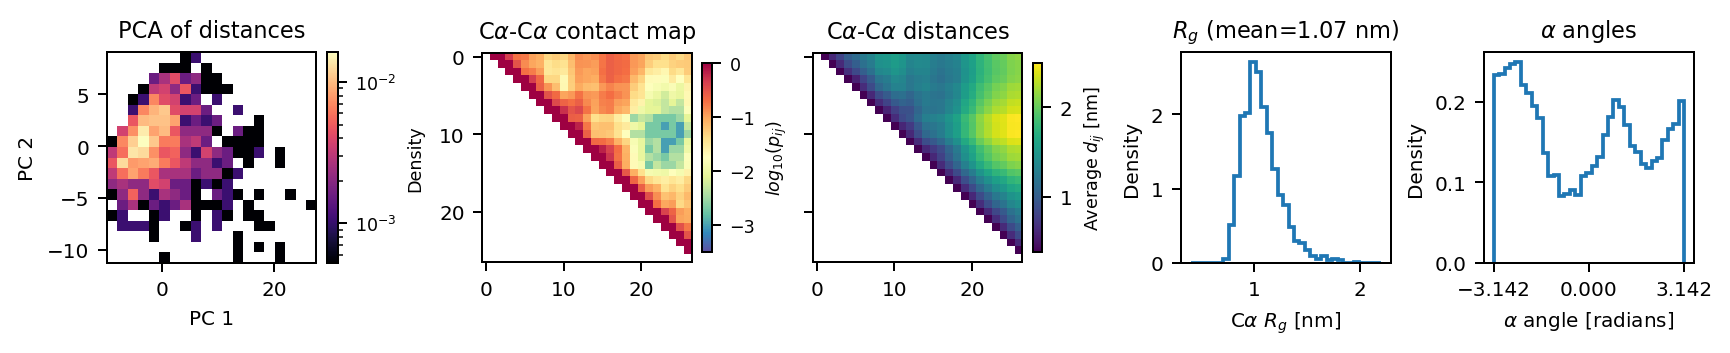

In [8]:
#@markdown **Visualize properties**

ax_title_size = 9
ax_label_size = 8  # 7.5
colorbar_shrink = 0.9
linewidth = 1.5

fig, ax = plt.subplots(1, 5,
                       layout='constrained',
                       figsize=(9.5, 1.85),
                       dpi=180)

##################
# PCA histogram. #
##################

pc_dim_x = 0
pc_dim_y = 1
n_pca_bins = 20
ax[0].set_title("PCA of distances", fontsize=ax_title_size)
ax[0].set_xlabel(f"PC {pc_dim_x+1}", fontsize=ax_label_size)
ax[0].set_ylabel(f"PC {pc_dim_y+1}", fontsize=ax_label_size)
ax[0].tick_params(axis='both', labelsize=ax_label_size)

if n_samples >= 100:
    hist = ax[0].hist2d(prot_data["pca"][:,pc_dim_x],
                        prot_data["pca"][:,pc_dim_y],
                        cmap="magma", bins=n_pca_bins,
                        norm=colors.LogNorm(), density=True)
    cbar = fig.colorbar(hist[-1], ax=ax[0])
    cbar.set_label("Density", fontsize=ax_label_size-1)
    cbar.ax.tick_params(labelsize=ax_label_size-1)
else:
    ax[0].scatter(prot_data["pca"][:,pc_dim_x],
                  prot_data["pca"][:,pc_dim_y],
                  marker=".")

################
# Contact map. #
################

ax[1].set_title(r"C$\alpha$-C$\alpha$ contact map", fontsize=ax_title_size)
cmap_min = -3.5  # 3
cmap = colormaps.get_cmap("Spectral_r")
norm = colors.Normalize(cmap_min, 0)
log_func = np.log10
pseudo_c = 1e-12
_cmap = log_func(prot_data["cmap"][0] + pseudo_c)
cmap_im = ax[1].imshow(_cmap,cmap=cmap, norm=norm,
                       aspect="equal")
max_ticks = 3
ax[1].xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
ax[1].yaxis.set_major_locator(plt.MaxNLocator(max_ticks))
ax[1].tick_params(axis='both', labelsize=ax_label_size)

cmap_cbar = fig.colorbar(
    cmap_im, ax=ax[1],
    location="right",
    shrink=colorbar_shrink,
)
cmap_cbar.set_label(r'$log_{10}(p_{ij})$',
                    fontsize=ax_label_size-1)
cmap_cbar.ax.tick_params(labelsize=ax_label_size-1)

#################
# Distance map. #
#################

ax[2].set_title(r"C$\alpha$-C$\alpha$ distances", fontsize=ax_title_size)
dmap_im = ax[2].imshow(prot_data["dmap"][0],
                       cmap=colormaps.get_cmap("viridis"))
ax[2].xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
ax[2].yaxis.set_major_locator(plt.MaxNLocator(max_ticks))
ax[2].set_yticklabels([])
ax[2].tick_params(axis='both', labelsize=ax_label_size)

cbar = fig.colorbar(dmap_im, ax=ax[2], location="right",
                    shrink=colorbar_shrink)
cbar.set_label(r"Average $d_{ij}$ [nm]",
               fontsize=ax_label_size-1)
cbar.ax.tick_params(labelsize=ax_label_size)

#################
# Rg histogram. #
#################

n_rg_bins = 35

ax[3].set_title(r"$R_g$ (mean={:.2f} nm)".format(prot_data["rg"].mean()),
                fontsize=ax_title_size)
rg_h_r = ax[3].hist(prot_data["rg"],
                    bins=np.linspace(0.4, 2.2, n_rg_bins+1),
                    histtype="step", density=True,
                    linewidth=linewidth)
ax[3].set_xlabel(r"C$\alpha$ $R_g$ [nm]", fontsize=ax_label_size)
ax[3].set_ylabel("Density", fontsize=ax_label_size)
ax[3].tick_params(axis='both', labelsize=ax_label_size)

#########################
# a torsions histogram. #
#########################

n_tors_bins = 35

ax[4].set_title(r"$\alpha$ angles", fontsize=ax_title_size)
ax[4].hist(prot_data["tors"],
    bins=np.linspace(-np.pi, np.pi, n_tors_bins+1),
    histtype="step", density=True,
    linewidth=linewidth)
ax[4].set_xlabel(r"$\alpha$ angle [radians]", fontsize=ax_label_size)
ax[4].set_ylabel("Density", fontsize=ax_label_size)
ax[4].set_xticks([-np.pi, 0, np.pi])
ax[4].tick_params(axis='both', labelsize=ax_label_size)
# ax[4].set_aspect("equal")

# plt.tight_layout()
plt.show()

In [9]:
#@title Optional: all-atom properties of the ensemble
#@markdown **Run the analysis**

if all_atom:

    print("# Analyzing...")

    aa_traj = mdtraj.load(cg2all_data["aa_dcd"],
                          top=cg2all_data["aa_top"])
    aa_traj.center_coordinates()
    aa_prot_data = {}

    # Rg
    print("- Computing Rg")
    aa_prot_data["rg"] = mdtraj.compute_rg(aa_traj)

    # DSSP.
    print("- Computing backbone properties")
    aa_prot_data["phi"] = mdtraj.compute_phi(aa_traj)
    aa_prot_data["psi"] = mdtraj.compute_psi(aa_traj)
    aa_prot_data["dssp"] = mdtraj.compute_dssp(aa_traj)

else:
    print("# Will not analyze all-atom properties.")

# Will not analyze all-atom properties.


In [10]:
#@markdown **Visualize properties**

if all_atom:

    ax_title_size = 9
    ax_label_size = 8  # 7.5
    colorbar_shrink = 0.9
    linewidth = 1.5

    fig, ax = plt.subplots(1, 3,
                           layout='constrained',
                           figsize=(6.5, 1.85),
                           dpi=180)

    #############################
    # Rg vs helicity histogram. #
    #############################

    n_rgh_bins = 20
    ax[0].set_title(r"$R_g$ vs helicity", fontsize=ax_title_size)
    ax[0].set_xlabel(r"$R_g$ [nm]", fontsize=ax_label_size)
    ax[0].set_ylabel("Helicity fraction", fontsize=ax_label_size)
    ax[0].tick_params(axis='both', labelsize=ax_label_size)

    helicity = np.mean(aa_prot_data["dssp"] == "H", axis=1)
    if n_samples >= 100:
        hist = ax[0].hist2d(aa_prot_data["rg"], helicity,
                            cmap="magma", bins=n_rgh_bins,
                            norm=colors.LogNorm(), density=True)
        cbar = fig.colorbar(hist[-1], ax=ax[0])
        cbar.set_label("Density", fontsize=ax_label_size-1)
        cbar.ax.tick_params(labelsize=ax_label_size-1)
    else:
        ax[0].scatter(aa_prot_data["rg"][:],
                      helicity, marker=".")

    ######################
    # Ramachandran plot. #
    ######################

    rama_bins = 50
    rama_linspace = np.linspace(-np.pi, np.pi, rama_bins)
    ax[1].set_title(r"Ramachandran plot", fontsize=ax_title_size)
    ax[1].set_xlabel(r"phi [radians]", fontsize=ax_label_size)
    ax[1].set_ylabel("psi [radians]", fontsize=ax_label_size)
    ax[1].tick_params(axis='both', labelsize=ax_label_size)

    hist = ax[1].hist2d(aa_prot_data["phi"][1].ravel(),
                        aa_prot_data["psi"][1].ravel(),
                        cmap="viridis", bins=(rama_linspace, rama_linspace),
                        norm=colors.LogNorm(), density=True)
    cbar = fig.colorbar(hist[-1], ax=ax[1])
    cbar.set_label("Density", fontsize=ax_label_size-1)
    cbar.ax.tick_params(labelsize=ax_label_size-1)

    ################################
    # Secondary structure profile. #
    ################################

    ax[2].set_title(r"DSSP states", fontsize=ax_title_size)
    for state, label in (("H", "helix"), ("E", "strand"), ("C", "coil")):
        ax[2].plot(np.arange(1, len(sequence)+1),
                   np.mean(aa_prot_data["dssp"] == state, axis=0), label=label)
    ax[2].legend(fontsize=ax_label_size-2)
    ax[2].set_xlabel("Residue index", fontsize=ax_label_size)
    ax[2].set_ylabel("Frequency", fontsize=ax_label_size)

    plt.show()

In [11]:
#@title Visualize 3D structures

import py3Dmol
#@markdown Choose the resolution:
show_all_atom = False #@param {type:"boolean"}

#@markdown Select the index of the conformation to visualize:
snapshot_id = 0 # @param {type:"integer"}

def extract_rgb_from_colormap(colormap_name, N):
    # Create a colormap object.
    colormap = plt.get_cmap(colormap_name)
    # Generate N equally spaced values between 0 and 1.
    points = np.linspace(0, 1, N)
    # Use the colormap to get colors for these points, converting to HTML format.
    colors = [colormap(point)[:3] for point in points] # Extract RGB, ignore A.
    html_colors = ['#' + ''.join([f'{int(val*255):02x}' for val in color]) for color in colors]
    return html_colors

def show_structure(snapshot, representation='aa', cmap_name='viridis'):
    pdb_fn = f'.temp.{time.time()}.pdb'
    snapshot.save(pdb_fn)
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    with open(pdb_fn, 'r') as i_fh:
        view.addModel(i_fh.read(), 'pdb')
    os.remove(pdb_fn)

    if representation == 'aa':
        view.setStyle({'cartoon': {'color': 'spectrum'},
                       'stick': {'color': 'spectrum'}})
    elif representation == 'cg':
        n_residues = snapshot.xyz.shape[1]
        colors = extract_rgb_from_colormap(cmap_name, n_residues)
        for i in range(n_residues):
            view.setStyle({'serial': str(i+1)},
                          {'sphere': {'color': colors[i],
                                      'radius': 1.9}})
    else:
        raise NotImplementedError(representation)

    view.zoomTo()
    return view

if not show_all_atom:
    snapshot = traj[snapshot_id]
    representation = 'cg'
else:
    snapshot = aa_traj[snapshot_id]
    representation = 'aa'
print('Blue is N-term. and red is C-term.')

view = show_structure(
    snapshot=snapshot,
    representation=representation,
    cmap_name='Spectral_r')
view.show()

Blue is N-term. and red is C-term.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

---

# 5 - Download results

In [12]:
#@title Download dcd files with the generated ensembles

#@markdown Run this cell to download a ZIP file containing the DCD

from google.colab import files

print("- Compressing the results in a ZIP file.")
!zip -r idpsam_results.zip output &> /dev/null
files.download("idpsam_results.zip")

- Compressing the results in a ZIP file.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>